# Assignment 8
Portfolio Optimization and Pair Trading Stategy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Modules from Lecture 11

In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from typing import Any, Union, Tuple

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def findOptPort(data_frames:pd.DataFrame, 
                target_ret:Any=None
                ) -> Tuple[float, float, np.ndarray]:
  """
    minimize half of port variance = 0.5 w^T\Sigma w
    such that
    1) Expected Return = target_ret (w^T\mu = target_ret)
    2) sum (w) = 1 (w^Tx1=1)
    :param data_frames: data_frames of simple returns
    :param target_ret: target return. None for minimum variance portfolio
    :return:
      r: expected annualized return
      vol: expected volatility
      w: weight on each stock in a portfolio
  """
  days_in_year = 365 # convert daily to yearly
  num_data, num_stocks = data_frames.shape 
  mu_vector  = data_frames.mean().values # mean vector
  cov_matrix = data_frames.cov().values # Sigma
  if target_ret is None: # minimum variance portfolio
    A = np.zeros((num_stocks + 1, num_stocks + 1)) 
    A[:num_stocks, :num_stocks] = cov_matrix 
    A[:num_stocks, -1] = -1
    A[-1, :num_stocks] = 1
    # A =[\Sigma | -1_N
    #     1_N^T      |0]
    # b = [0_N^T | 1]^T
    b = np.zeros(num_stocks + 1)
    b[:num_stocks] = 0
    b[-1] = 1
    x = np.linalg.solve(A, b)     
    w = x[:-1]
    r_min = x[-1] # daily return at minimum variance portfolio
    vol = np.sqrt(np.dot(np.dot(w.T, cov_matrix), w) * days_in_year)
    r = r_min * days_in_year # yearly return
    return r, vol, w  
  else:
    #  A = [Sigma| -1_N ,-\mu
    #       1_N^T|0,       0 
    #       \mu  |0,       0]
    #
    # b =[0_N,^T target_ret, 1]^T
    A = np.zeros((num_stocks + 2, num_stocks + 2))
    A[:num_stocks, :num_stocks] = cov_matrix
    A[:num_stocks, -1] = -1
    A[-1, :num_stocks] = 1
    A[:num_stocks, -2] = -mu_vector
    A[-2, :num_stocks] = mu_vector
    b = np.zeros(num_stocks + 2)
    b[:num_stocks] = 0
    b[-2] = target_ret/ days_in_year # convert to daily return
    b[-1] = 1
    x = np.linalg.solve(A, b)
    w = x[:num_stocks]
    vol = np.sqrt(np.dot(np.dot(w.T, cov_matrix), w) * days_in_year)
    r = target_ret
    return r, vol, w

In [ ]:
def buildEfficientFrontier(data_frames:pd.DataFrame,
                           plot_graph:bool = False
                           ) -> Tuple[np.ndarray, np.ndarray]:
  """
  compute the efficient frontier for a given 
  historical simple returns
    :param data_frames: data_frames of simple returns
    :param plot_graph: True to plot the efficient frontier
    :return: 
    mean and volatility of efficient fronteir
  """
  days_in_year = 365
  num_data, num_stocks = data_frames.shape  
  mu_vect  = data_frames.mean()
  cov_mat = data_frames.cov()
  stock_names = data_frames.columns  
  ret_stock = mu_vect * days_in_year
  vol_stock  = data_frames.std() * np.sqrt(days_in_year)
  r_max = ret_stock.max() * 3
  
  if plot_graph: # example stock to plot
    num_shows = int(0.1*num_stocks)
    showed_stocks = np.random.choice(stock_names, size=num_shows)
    vol_show = vol_stock[showed_stocks]
    mean_show = ret_stock[showed_stocks]
    plt.scatter(vol_show, mean_show, c='red')
    for stock in showed_stocks:
      plt.text(vol_show[stock]*1.02, mean_show[stock],stock)
  # find the efficient frontiers
  r_min, vol_min, w_min = findOptPort(data_frames) 
  mean_array = np.linspace(r_min, r_max, 1000)
  vol_array = np.zeros((1000,))
  for k, rk in enumerate(mean_array):
    r, vol, w = findOptPort(data_frames, target_ret =  rk)     
    vol_array[k] = vol
  if plot_graph:
    plt.plot(vol_array, mean_array)
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.title(f"Return vs Volatility of top {num_stocks} SET Stocks")
    plt.grid()
    plt.show()
  return vol_array, mean_array

In [ ]:
import scipy.optimize as opt 
def findMarketPortfolio(data_frames: pd.DataFrame, 
                        rf:float
                        ) -> Tuple[np.ndarray, float, float]:
  """
    Find Market Portfolio for a given risk-free interest rate
    :param data_frames: data_frames of simple returns
    :param rf: risk-free interest rate
    :return:
      w_opt: Market portfolio 
      vol_opt: volatility of the market portfolio 
      ret_best: return of the market portfolio 
  """
  def sharpe_ratio(target_ret):
    ret, vol, w = findOptPort(data_frames, target_ret)
    return (ret - rf)/vol  
  r_max = -1e100
  days_in_year = 365
  num_data, num_stocks = data_frames.shape  
  r_min, vol_min, w_in = findOptPort(data_frames)
  best_solution = opt.minimize(lambda x: -sharpe_ratio(x), r_min)
  ret_best = best_solution['x'][0]
  _,vol_opt, w_opt = findOptPort(data_frames, target_ret= ret_best)
  return w_opt , vol_opt, ret_best


In [ ]:
def plotCapitalMarketLine(data_frames:pd.DataFrame,
                          w_market:np.ndarray, 
                          vol_market:float, 
                          ret_market:float,
                          rf:float):
  """
  Plot the capital market line
  :param data_frames: Simple return 
  :param w_market: Market Portfolio
  :param vol_mark: Market Portfolio volatility
  :param: ret_market: Maker Portfolio Return
  :parma: rf: risk-free interest
  """
  vols, rets = buildEfficientFrontier(data_frames, plot_graph=False)
  slope = (ret_market - rf)/vol_market
  ret_array_line = vols*slope + rf
  plt.plot(vols, rets, vols, ret_array_line)
  plt.scatter(vol_market, ret_market, c="red")
  plt.text(vol_market*1.01, ret_market, "Market Portfolio")
  plt.xlabel("volatility")
  plt.ylabel("return")
  plt.grid()
  title = "Capital Market Line with "
  for symbol in data_frames.columns:
    title += symbol +" "
  plt.title(title)
  plt.legend(["Efficient Frontier", "Capital Market Line"])
  plt.show()


In [ ]:
!pip install qpsolvers
from qpsolvers import solve_qp
def findOptPortLongOnly(data_frames: pd.DataFrame,
                        target_ret:float)->Tuple[float, float, np.ndarray]:
  """
    :param data_frames: data_frames of simple returns
    :param target_ret: target return. None for minimum variance portfolio
    :return:
      r: expected annualized return
      vol: expected volatility
      w: weight on each stock in a portfolio

  """
  days_in_year = 365
  num_data, num_stocks = data_frames.shape  
  mu_vector  = data_frames.mean().values
  cov_matrix = data_frames.cov().values
  num_stocks = mu_vector.shape[0]
  P = cov_matrix
  q = np.zeros((num_stocks,))
  G = np.ones((1, num_stocks))
  h = np.array([1])
  A = mu_vector.reshape(1,-1)
  b = np.array([target_ret/days_in_year])
  lb = np.zeros((num_stocks,))
  ub = np.ones((num_stocks,))
  w = solve_qp(P,q,G,h,A,b,lb,ub,verbose=True, solver='cvxopt')
  vol = np.sqrt(np.dot(np.dot(w.T, cov_matrix),w) *days_in_year)
  r = np.dot(mu_vector,w) * days_in_year
  return r, vol, w


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def buildEfficientFrontierLongOnly(data_frames:pd.DataFrame,
                                   plot_graph:bool = False
                                   )->Tuple[np.ndarray, np.ndarray]:
  """
    Build Efficient Frontier for long only portfolio
    :param data_frames: data_frames of simple returns
    :return:
    vol_array: volatility of efficinet frontier
    mean_array: return of efficinet frontier
  """
  days_in_year = 365
  num_data, num_stocks = data_frames.shape  
  mu_vect  = data_frames.mean().values  
  r_min = 0
  r_max = mu_vect.max()*days_in_year
  mean_array = np.linspace(r_min, r_max, 1000)
  vol_array = np.zeros((1000,))
  for k in range(1000):
    rk,volk, wk = findOptPortLongOnly(data_frames, target_ret=mean_array[k])
    vol_array[k] = volk
  if plot_graph:
    plt.plot(vol_array, mean_array)
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.title(f"Return vs Volatility of {num_stocks} SET Stocks")
    plt.grid()
    plt.show()
  return vol_array, mean_array

## Modules from Lecture 12

In [ ]:
class STATUS:
  LONG = "long"
  SHORT = "short"
  NO_POSITION = "no position"

In [ ]:
from sklearn.linear_model import LinearRegression # build Linear Regression Line
from statsmodels.tsa.stattools import adfuller # ADF Test for statistionart 
def buildLinearRegression(y1, y2):
  lin_model = LinearRegression() # initialize linear regression
  y = y1.values
  x = y2.values.reshape(-1,1) # always need to be nx1
  lin_model.fit(x, y)
  error = y - lin_model.predict(x)
  statistics,p_value,*_ = adfuller(error) # get only statistic and p-value ignore the rest
  return lin_model, statistics, p_value


In [ ]:
# Note that z = p1 - a * p2 - b
# we cannot long or short b. Thus, we will long and short only p1 -a * p2
def longSpread(p1t, p2t, a, cash, trans_cost=0):
  if a > 0: # long p1 and short p2
    p1_actual_price = p1t * (1 + trans_cost) # pay more when long
    p2_actual_price = p2t * (1 - trans_cost) # get less when short
  else: # long both p1 and p2 
    p1_actual_price = p1t * (1 + trans_cost) # long P1
    p2_actual_price = p2t * (1 + trans_cost) # long P2
  spread_share = cash / (p1_actual_price + np.abs(a) * p2_actual_price) 
  # Do not use cash more than what we have 
  s1 = spread_share # always long
  cash -= s1 * p1_actual_price # cash pays for buying s1
  s2 = -a * spread_share # stock2 that we owe
  cash -= s2 * p2_actual_price # get from short s2
  return s1, s2, cash

def shortSpread(p1t, p2t, a, cash, trans_cost=0):
  if a > 0: # short p1 and long p2
    p1_actual_price = p1t * (1 - trans_cost) # pay more when long
    p2_actual_price = p2t * (1 + trans_cost) # get less when short
  else: # short both p1 and p2 
    p1_actual_price = p1t * (1 - trans_cost)
    p2_actual_price = p2t * (1 - trans_cost)
  spread_share = cash / (p1_actual_price  + np.abs(a) * p2_actual_price) 
  # Do not use cash more than what we have 
  s1 = -spread_share # alway shorts
  cash -= s1 * p1_actual_price # cash pays for buying s1
  s2 = a * spread_share # stock2 that we owe
  cash -= s2 * p2_actual_price # get from short s2
  return s1, s2, cash


def closePosition(p1t, p2t, s1, s2, a, status, trans_cost=0):
  sign_a = np.sign(a)
  if status == STATUS.LONG: # close from long spread
    cash1 = s1 * p1t * (1 - sign_a * trans_cost) # get less due to long
    cash2 = s2 * p2t * (1 + sign_a * trans_cost) # pay more due to short
  elif status == STATUS.SHORT: # close from short spread
    cash1 = s1 * p1t * (1 + sign_a * trans_cost) # get less due to short
    cash2 = s2 * p2t * (1 - sign_a * trans_cost) # pay more due to long
  else:
    raise ValueError(f"status can be either {STATUS.LONG} or {STATUS.SHORT}")
  return cash1 + cash2

In [ ]:
def pairTrade(p1, p2, z_th, a, b, init_wealth=1_000_000, trans_cost=0):
  status = STATUS.NO_POSITION
  stock1 = stock2 = 0
  cash = init_wealth
  wealth = pd.Series()
  signal = pd.Series()
  for k, (p1t, p2t, t_k) in enumerate(zip(p1,p2, p1.index)):
    e = p1t - a * p2t - b
    if status == STATUS.NO_POSITION:
      if e > z_th: # SHORT SELL Spread
        stock1, stock2, cash = shortSpread(p1t, p2t, a, cash, trans_cost)
        status = STATUS.SHORT
      elif e < -z_th: # Long 
        stock1, stock2, cash = longSpread(p1t, p2t, a, cash, trans_cost)
        status = STATUS.LONG
    elif status == STATUS.LONG:
      if e >= 0: # Close Long Position
        cash += closePosition(p1t, p2t, stock1, stock2, a, status, trans_cost)
        stock1 = stock2 = 0
        status = STATUS.NO_POSITION
    else: # STATUS == STATUS.SHORT
      if e <=0 : # Close short position
        cash += closePosition(p1t, p2t, stock1, stock2, a, status, trans_cost)
        stock1 = stock2 = 0
        status = STATUS.NO_POSITION
    if status == STATUS.NO_POSITION:
      signal[t_k] = 0
    elif status == STATUS.LONG:
      signal[t_k] = 1
    else:
      signal[t_k] = -1
    cur_wealth = p1t * stock1 + p2t*stock2 + cash
    wealth[t_k] = cur_wealth
    #print(f"{status}, {stock1}, {stock2}, {cash}")
  return wealth, signal

In [ ]:
reg_models = dict()
min_adf = np.inf
for col in prices.columns:
  x0 = prices[col]
  x1 = prices.drop(col, axis=1)
  lin_model = LinearRegression()
  lin_model.fit(x1,x0) 
  x0_hat = lin_model.predict(x1)
  error = x0 - x0_hat 
  adf, p_value, *_ = adfuller(error, maxlag=1)
  # print(col, adf, p_value)
  reg_models[col] = lin_model
  if min_adf > adf:
    best_model = lin_model
    min_adf = adf
    best_p_value = p_value
    target = col 
    opt_coef = lin_model.coef_
    opt_intercept = lin_model.intercept_
    best_x1 = x1
    best_x0 = x0
print(f"Best model is to predict {target} with ADF: {min_adf} and p_value: {best_p_value}")

NameError: ignored

# 1. Find Efficient Market Porfolio in 2021 from stocks in the list given below

In [ ]:
# SET50 & SET100 INDEX CONSTITUENTS (Published on Dec 17, 2021)
# For calculating the index during Jan 1 - Jun 30, 2022
#set50 = ['ADVANC', 'AOT', 'AWC', 'BANPU', 'BBL', 'BDMS', 'BEM', 'BGRIM', 'BH','BTS', #'BLA', #BLA New?
#          'CBG','COM7', 'CPALL', 'CPF', 'CPN', 'CRC', 'DTAC', 'EA', 'EGCO', 'GLOBAL', #CENTEL #COM7 #DELTA #DTAC
#         'GPSC', 'GULF', 'HMPRO', 'INTUCH', 'IRPC', 'IVL', 'KBANK', 'KCE','KTB', 'KTC',  # 'JMART', 'JMT'
#          'LH', 'MINT', 'MTC','OR', 'OSP', 'PTT', 'PTTEP', 'PTTGC','RATCH', 'SAWAD', 
#         'SCB','SCC', 'SCGP','STGT','TIDLOR', 'TISCO', 'TOP', 'TRUE', 'TTB', 'TU'] 

set50 = ['ADVANC', 'AOT', 'AWC', 'BANPU', 'BBL', 'BDMS', 'BEM', 'BGRIM', 'BH', 
         'BLA', 'BTS', 'CBG', 'CPALL', 'CPF', 'CPN', 'CRC', 'DTAC', 'EA', 
         'EGCO', 'GLOBAL', 'GPSC', 'GULF', 'HMPRO', 'INTUCH', 'IRPC', 'IVL', 
         'JMART', 'JMT', 'KBANK', 'KCE', 'KTB', 'KTC', 'LH', 'MINT', 'MTC', 
          'OSP', 'PTT', 'PTTEP', 'PTTGC', 'SAWAD', 'SCC', 'SCGP',
         'TIDLOR', 'TISCO', 'TOP', 'TRUE', 'TTB', 'TU']

In [ ]:
set50prices = dict()
for stock in set50:
  df = yf.download(stock+".BK","2021-01-01", "2021-12-31") 
  close = df['Adj Close']#.resample("1D").ffill() 
  set50prices[stock] = close
set50prices = pd.DataFrame(set50prices)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
retset50 = set50prices.pct_change(1).dropna()

In [ ]:
retset50.head()

,ADVANC,AOT,AWC,BANPU,BBL,BDMS,BEM,BGRIM,BH,BLA,...,PTTGC,SAWAD,SCC,SCGP,TIDLOR,TISCO,TOP,TRUE,TTB,TU
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-11,0.005882,0.000000,-0.012552,-0.062500,-0.004202,-0.009346,-0.018987,-0.011834,-0.003891,-0.010477,...,-0.007246,-0.027950,0.017316,-0.013158,-0.060109,-0.011268,-0.012448,-0.006211,-0.008621,0.059524
2021-05-12,-0.008772,-0.012346,0.000000,-0.016667,-0.012658,-0.014151,-0.006452,0.005988,-0.015625,0.127451,...,-0.018248,-0.067093,-0.017021,-0.031111,-0.063953,-0.014245,-0.012605,-0.012500,-0.008696,0.016854
2021-05-13,-0.002950,0.000000,-0.008475,-0.008475,0.004273,-0.009569,-0.019480,-0.029762,0.003968,0.086957,...,-0.003717,0.013699,-0.004329,-0.004587,0.018634,0.000000,0.004255,-0.018987,-0.008772,-0.011050
2021-05-14,0.002959,-0.004167,-0.008547,0.017094,-0.017021,0.019324,0.000000,-0.012270,0.003953,0.008000,...,0.007463,-0.033784,0.008696,0.009217,-0.012195,0.000000,-0.008475,-0.006452,-0.008850,0.033520
2021-05-17,-0.005900,0.012552,0.000000,0.008403,0.004329,-0.009479,-0.006623,-0.006211,-0.003937,0.000000,...,-0.007407,0.027972,-0.038793,0.050228,0.024691,0.008671,0.000000,-0.012987,0.000000,0.005405


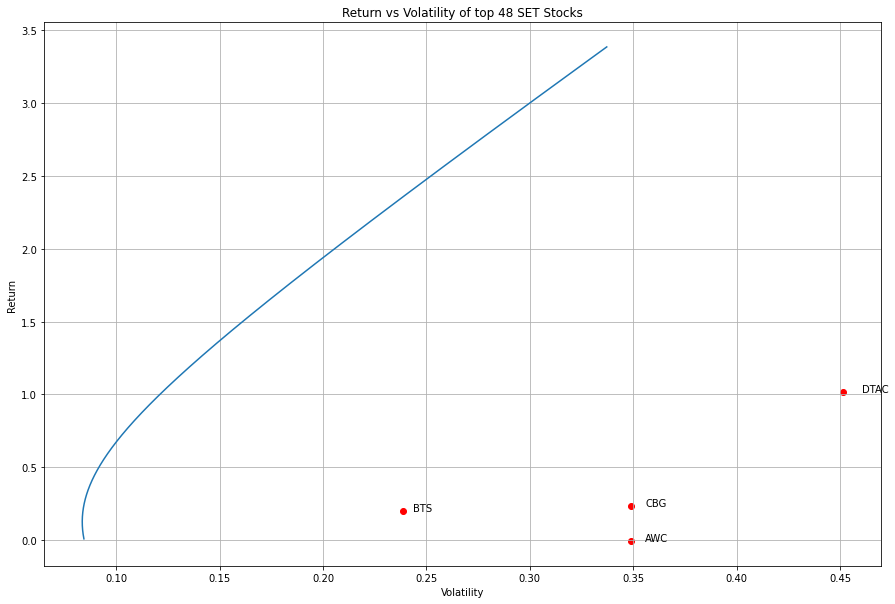

In [ ]:
plt.figure(figsize=(15,10))
vol_array,mean_array = buildEfficientFrontier(retset50,plot_graph=True)

## Solution: Find the top 5 stocks in the market portfolio. Here, we only consider the magnitude 
1. _____ Position:_____
2. _____ Position:_____
3. _____ Position:_____
4. _____ Position:_____
5. _____ Position:_____

# 2. Do you think it is possible to construct the market portfolio? why?

## Solution: 

#3. Plot the Capital Market Line where $r_f=2\%$

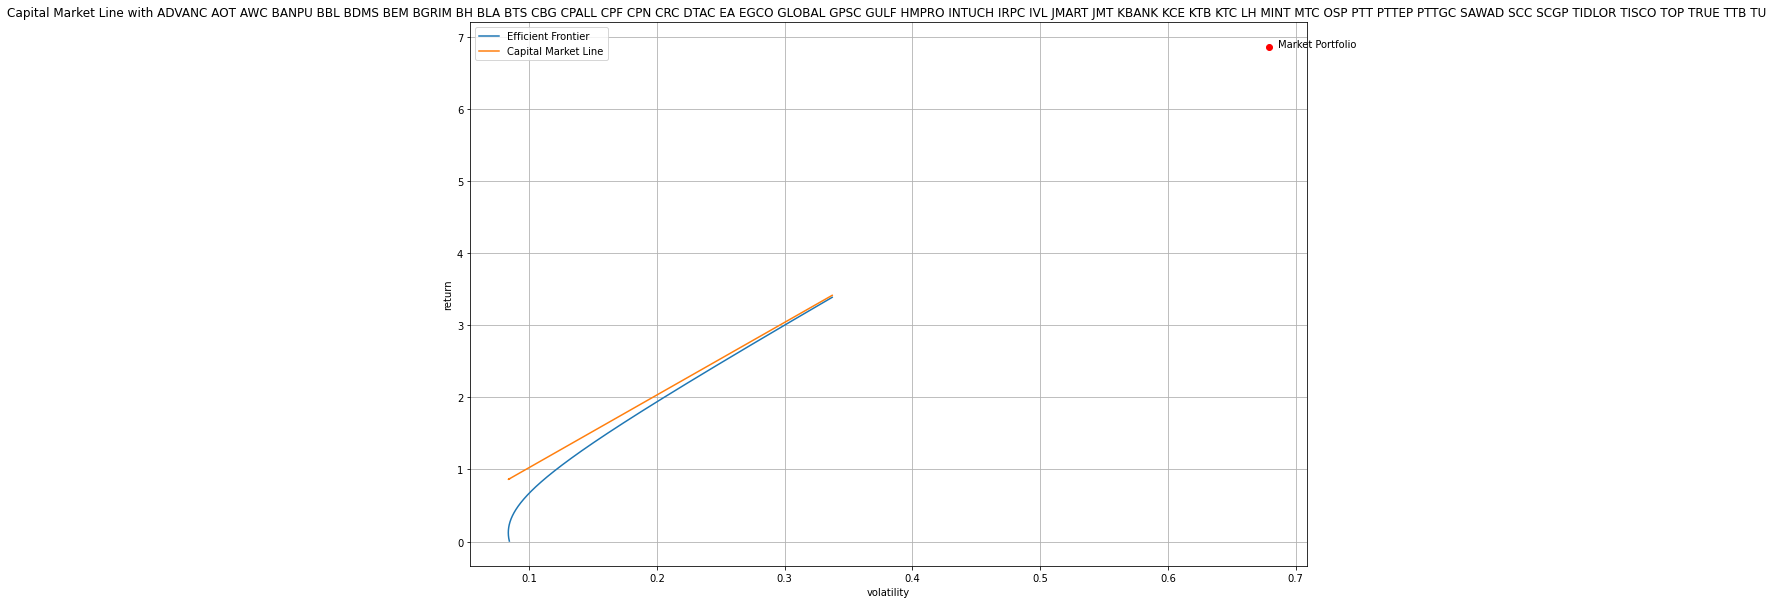

In [ ]:
# Add your code here
plt.figure(figsize=(15,10))
w_opt , vol_opt, ret_best = findMarketPortfolio(retset50, rf=0.02)
plotCapitalMarketLine(retset50, w_opt, vol_opt, ret_best,rf=0.02)

In [ ]:
w_opt

array([ 1.09066582,  0.25728936, -0.41785088, -0.06886567, -0.67045305,
        0.26970803,  1.11192064, -1.28869954,  0.33742164,  0.14503499,
        0.37063172, -0.23375613,  0.14927185,  0.00534633,  0.27092816,
       -0.83375905,  0.16812669,  0.70103017, -0.92483333, -0.57715973,
        0.55216108,  0.81848312,  0.42720435,  0.142633  , -0.11528728,
        0.30955842, -0.2003257 ,  0.68562121,  1.15494548,  0.16663305,
        0.52579038, -0.42219887,  0.91356264, -0.17308887,  0.54674045,
        0.08778737,  0.24626465,  0.39678461, -0.31729122, -0.65870151,
       -2.218629  ,  0.49104538, -0.76602502, -0.2704267 , -0.50405699,
       -0.24116198, -0.34271446, -0.09730558])

# 4. Find the Beta of all stock against the market portfolio. 
Report Stock with higest Beta, and all
stocks with negative beta

In [ ]:
# code here
retport = np.dot(w_opt, retset50.values.T)
Betas = dict()
for k in range(len(retset50.columns)):
  name = retset50.columns[k]
  retk = retset50[name]
  beta = np.corrcoef(retk, retport)[0,1]
  beta = beta * retk.var(ddof=1) / retport.var(ddof=1) 
  Betas[name] = beta
  print(f"Stock {name}: {beta:0.2f}")

Stock ADVANC: 0.04
Stock AOT: 0.00
Stock AWC: -0.00
Stock BANPU: -0.03
Stock BBL: 0.01
Stock BDMS: 0.01
Stock BEM: 0.01
Stock BGRIM: -0.00
Stock BH: 0.01
Stock BLA: 0.11
Stock BTS: 0.01
Stock CBG: 0.02
Stock CPALL: -0.00
Stock CPF: -0.01
Stock CPN: 0.01
Stock CRC: -0.01
Stock DTAC: 0.10
Stock EA: 0.10
Stock EGCO: 0.00
Stock GLOBAL: -0.02
Stock GPSC: 0.03
Stock GULF: 0.05
Stock HMPRO: 0.01
Stock INTUCH: 0.05
Stock IRPC: -0.01
Stock IVL: -0.02
Stock JMART: 0.10
Stock JMT: 0.11
Stock KBANK: 0.03
Stock KCE: 0.08
Stock KTB: 0.03
Stock KTC: -0.04
Stock LH: 0.01
Stock MINT: -0.00
Stock MTC: -0.01
Stock OSP: -0.00
Stock PTT: -0.00
Stock PTTEP: -0.00
Stock PTTGC: -0.02
Stock SAWAD: -0.04
Stock SCC: -0.02
Stock SCGP: 0.03
Stock TIDLOR: -0.04
Stock TISCO: 0.01
Stock TOP: -0.03
Stock TRUE: 0.09
Stock TTB: 0.04
Stock TU: 0.03


In [ ]:
Betas_top = sorted(Betas, key=Betas.get, reverse=True)
print(f"Highest Beta: {Betas_top[0]} \nNegative Beta: {Betas_top[-1]}")

Highest Beta: BLA 
Negative Beta: SAWAD


## Solution:
Highest Beta: ______

Negative Beta:

  Stock1: ____ Beta:____

  ... 

#5. Use the set50 index in set50Index2022.xlsx as the market portfolio. Compute Beta of all stocks. Find the highest Beta and all Negative one.

In [ ]:
# Code is here
SET50_INDEX = pd.read_excel('/content/drive/MyDrive/Finance/set50Index2022.xlsx')  

In [ ]:
SET50_INDEX.head()

,Date,Value
0,2022-12-30,1005.24
1,2022-12-29,1010.19
2,2022-12-28,1000.54
3,2022-12-27,996.07
4,2022-12-26,983.51


In [ ]:
SET50_INDEX_new = SET50_INDEX.set_index(['Date'])
SET50_INDEX_new 

,Value
Date,
2022-12-30,1005.24
2022-12-29,1010.19
2022-12-28,1000.54
2022-12-27,996.07
2022-12-26,983.51
...,...
2022-01-10,985.79
2022-01-07,985.96
2022-01-06,983.71


In [ ]:
retSET50_INDEX = SET50_INDEX_new.pct_change(1).dropna()

In [ ]:
retSET50_INDEX

,Value
Date,
2022-12-29,0.004924
2022-12-28,-0.009553
2022-12-27,-0.004468
2022-12-26,-0.012610
2022-12-23,-0.005389
...,...
2022-01-10,-0.006080
2022-01-07,0.000172
2022-01-06,-0.002282


## Solution:
Highest Beta: ______

Negative Beta:

  Stock1: ____ Beta:____

  ... 

# 6. We will use Data in 2017-2021 to find 1 pair trade of set 50.
The criteria in choosing the pair are given below
1. For a spread defined as $ɛ_t = y_{1t} - \gamma\times y_{2t} - \mu$, we want stock with negative $\gamma$, i.e., $\gamma < 0$ so that we will take long and short positions on both stock when trading on the spread.
2. $p$-value must be the smallest among pairs in (1).

In [ ]:
# Code is here
close_prices = dict()
for sym in set50:
  ticker = yf.Ticker(sym + ".BK")
  prices = ticker.history(start="2017-01-01", end="2021-12-31")
  close_prices[sym] =prices['Close']

In [ ]:
from itertools import combinations # Make all possible Pair combination
regression_models = dict()
for sym1, sym2 in combinations(set50,2):
  y1 = close_prices[sym1]
  y2 = close_prices[sym2]
  if len(y1) != len(y2):
    print(f"{sym1} and {sym2} cannot be used in pair trade")
    continue
  print(f"Determining the possibility to pair trade in {sym1} and {sym2}")
  lin_model_12, stat12, p_val12 = buildLinearRegression(y1, y2)
  lin_model_21, stat21, p_val21 = buildLinearRegression(y2, y1)
  if p_val12 < p_val21: # y2 predict y1 is better
    regression_models[sym1, sym2] = [lin_model_12, stat12, p_val12]
    print(f"{sym2} predicts {sym1} is better with p-value: {p_val12}")
  else:
    regression_models[sym2, sym1] = [lin_model_21, stat21, p_val21]
    print(f"{sym1} predicts {sym2} is better with p-value: {p_val21}")

Determining the possibility to pair trade in ADVANC and AOT
ADVANC predicts AOT is better with p-value: 0.17233509812373
ADVANC and AWC cannot be used in pair trade
Determining the possibility to pair trade in ADVANC and BANPU
BANPU predicts ADVANC is better with p-value: 0.2985220245021597
Determining the possibility to pair trade in ADVANC and BBL
BBL predicts ADVANC is better with p-value: 0.34399464507803934
Determining the possibility to pair trade in ADVANC and BDMS
ADVANC predicts BDMS is better with p-value: 0.010761208085349298
Determining the possibility to pair trade in ADVANC and BEM
ADVANC predicts BEM is better with p-value: 0.3451959098984213
ADVANC and BGRIM cannot be used in pair trade
Determining the possibility to pair trade in ADVANC and BH
BH predicts ADVANC is better with p-value: 0.3246442233297256
Determining the possibility to pair trade in ADVANC and BLA
BLA predicts ADVANC is better with p-value: 0.7223933430738138
Determining the possibility to pair trade in

In [ ]:
sorted_models = dict(sorted(regression_models.items(), key=lambda x: x[1][2]))


In [ ]:
print(sorted_models)

{('BDMS', 'PTTEP'): [LinearRegression(), -5.662133002379176, 9.327618497589841e-07], ('CPF', 'TTB'): [LinearRegression(), -5.344138397538602, 4.433252316070662e-06], ('CPF', 'KBANK'): [LinearRegression(), -5.2130244811860935, 8.269436118898185e-06], ('CPF', 'BH'): [LinearRegression(), -5.028684289390598, 1.9467853108212252e-05], ('CPF', 'TOP'): [LinearRegression(), -4.973039521236336, 2.5087615444085643e-05], ('CPF', 'TRUE'): [LinearRegression(), -4.73682839969572, 7.172154148429612e-05], ('CPF', 'IRPC'): [LinearRegression(), -4.703562656069258, 8.286549284227812e-05], ('CPF', 'BANPU'): [LinearRegression(), -4.647035403459351, 0.00010569922790782547], ('CPF', 'CPN'): [LinearRegression(), -4.57003364719814, 0.00014663318302978462], ('CPF', 'KTB'): [LinearRegression(), -4.542918081272697, 0.00016435607998589963], ('PTT', 'LH'): [LinearRegression(), -4.057225914496169, 0.0011387903235466899], ('BDMS', 'PTT'): [LinearRegression(), -4.055316440855423, 0.001147007413315396], ('BH', 'IRPC'): 

[0.10555953] 11.122236365930725


Text(0.5, 1.0, '$\\hat{\\varepsilon} = y_{BDMS} - 0.1 * y_{PTTEP} - 11.12$')

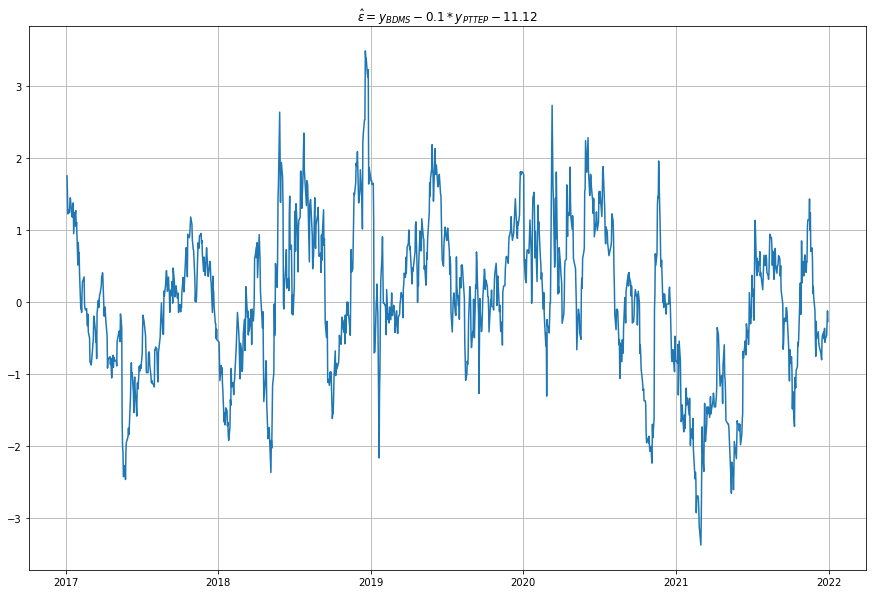

In [ ]:
Best_model, stat, p_value = sorted_models['BDMS', 'PTTEP']
print(Best_model.coef_, Best_model.intercept_)
error = close_prices['BDMS'] - Best_model.coef_* close_prices['PTTEP']
error -= Best_model.intercept_
plt.figure(figsize=(15,10))
plt.plot(error)
plt.grid()
plt.title(r"$\hat{\varepsilon} = y_{BDMS} - 0.1 * y_{PTTEP} - 11.12$")

Solution: This pair is 'BDMS' and 'PTTEP' Here, we will use 'PTTEP' to predict 'BDMS'

## Solution: This pair is (1) ___ and (2) ___. Here, we will use (2) to predict (1)

# 9. Perform Pair Trade with both Long and Short Spread with $N/T = 0.10$ and transcation cost = 1%




In [ ]:
from scipy.stats import norm
stdz = error.std()
PerPo = norm.ppf(1 - 0.1) #--> Percent point function N/T=0.10
s0 = stdz * PerPo
s0

1.3547933818193985

In [ ]:
# code here
a,b = Best_model.coef_, Best_model.intercept_
wealth, signal = pairTrade(close_prices['BDMS'], close_prices['PTTEP'], z_th = s0, a = a , b = b, init_wealth=1_000_000, trans_cost=0.01)

<ipython-input-84-9ffb9b667ce4>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wealth = pd.Series()
<ipython-input-84-9ffb9b667ce4>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series()


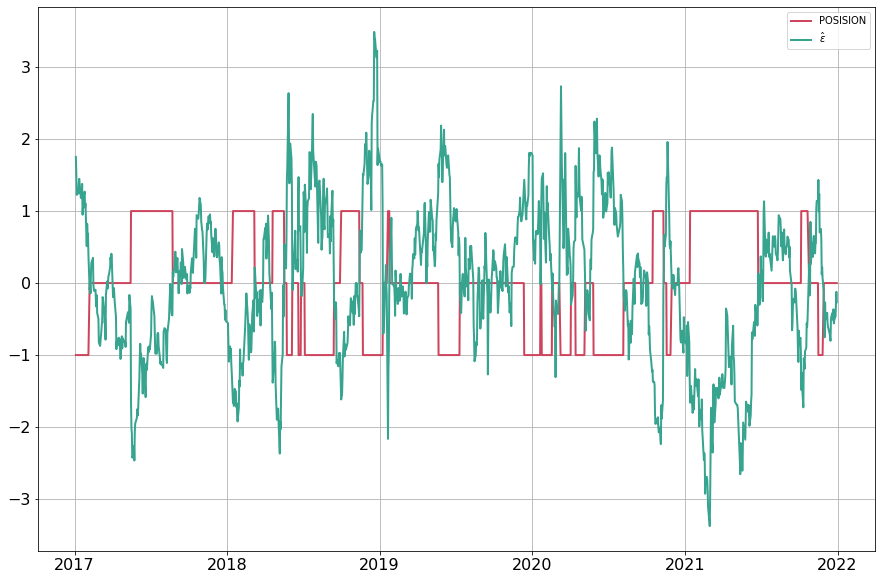

In [ ]:
## plotting data vectors 
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)

ax1.tick_params(axis='both',which='major',labelsize=16)
ax1.plot(signal,label='POSISION',color='#CE445D',linewidth=2)
ax1.plot(error,label= r"$\hat{\varepsilon}$",color='#37A490',linewidth=2)
ax1.legend()
ax1.grid(True)
plt.show()

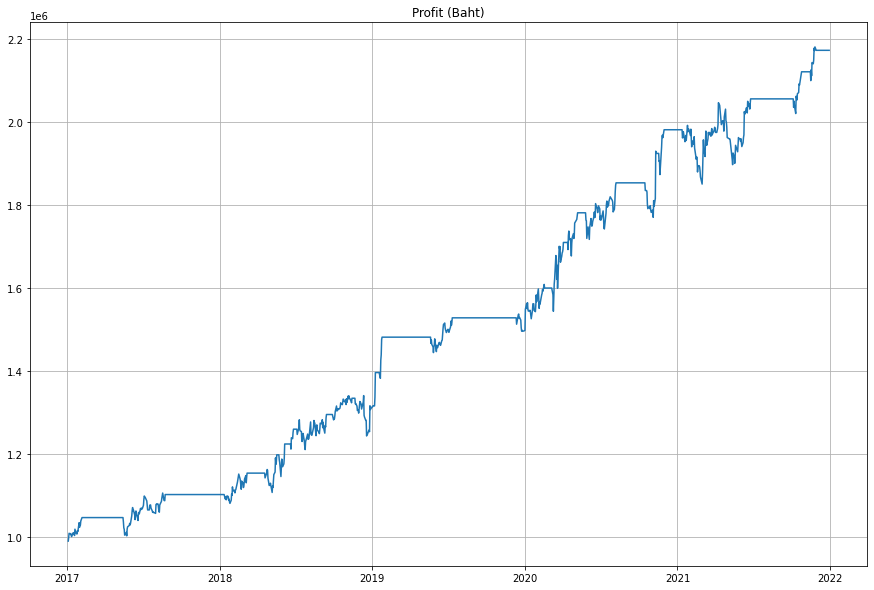

In [ ]:
wealth
plt.figure(figsize=(15,10))
plt.plot(wealth)
plt.title('Profit (Baht)')
plt.grid()

In [ ]:
print(f"Gain(or Loss) at the end of 2021: {(wealth[-1]*(1/10000))}")

Gain(or Loss) at the end of 2021: [217.17901187]


## Solution:
* Gain(or Loss) at the end of 2021: Gain.
* Number of Long: 8 and Short: 13 during 5 years.

# 10. Perform Pair Trade with **Long** Only on the Spread with $N/T = 0.1$

In [ ]:
def pairTradeLongOnly(p1, p2, z_th, a, b, init_wealth=1_000_000, trans_cost=0):
  status = STATUS.NO_POSITION
  stock1 = stock2 = 0
  cash = init_wealth
  wealth = pd.Series()
  signal = pd.Series()
  for k, (p1t, p2t, t_k) in enumerate(zip(p1,p2, p1.index)):
    e = p1t - a * p2t - b
    if status == STATUS.NO_POSITION:
      #if e > z_th: # SHORT SELL Spread
      #  stock1, stock2, cash = shortSpread(p1t, p2t, a, cash, trans_cost)
      #  status = STATUS.SHORT
      if e < -z_th: # Long 
        stock1, stock2, cash = longSpread(p1t, p2t, a, cash, trans_cost)
        status = STATUS.LONG
    elif status == STATUS.LONG:
      if e >= 0: # Close Long Position
        cash += closePosition(p1t, p2t, stock1, stock2, a, status, trans_cost)
        stock1 = stock2 = 0
        status = STATUS.NO_POSITION
    #else: # STATUS == STATUS.SHORT
    #  if e <=0 : # Close short position
    #    cash += closePosition(p1t, p2t, stock1, stock2, a, status, trans_cost)
    #    stock1 = stock2 = 0
    #    status = STATUS.NO_POSITION
    if status == STATUS.NO_POSITION:
      signal[t_k] = 0
    elif status == STATUS.LONG:
      signal[t_k] = 1
    #else:
    #  signal[t_k] = -1
    cur_wealth = p1t * stock1 + p2t*stock2 + cash
    wealth[t_k] = cur_wealth
    #print(f"{status}, {stock1}, {stock2}, {cash}")
  return wealth, signal

In [ ]:
# build your own long only spread trading
a,b = Best_model.coef_, Best_model.intercept_
wealth_L, signal_L = pairTradeLongOnly(close_prices['BDMS'], close_prices['PTTEP'], z_th = s0, a = a , b = b, init_wealth=1_000_000, trans_cost=0.01)

<ipython-input-243-26cbb16a10a5>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wealth = pd.Series()
<ipython-input-243-26cbb16a10a5>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series()


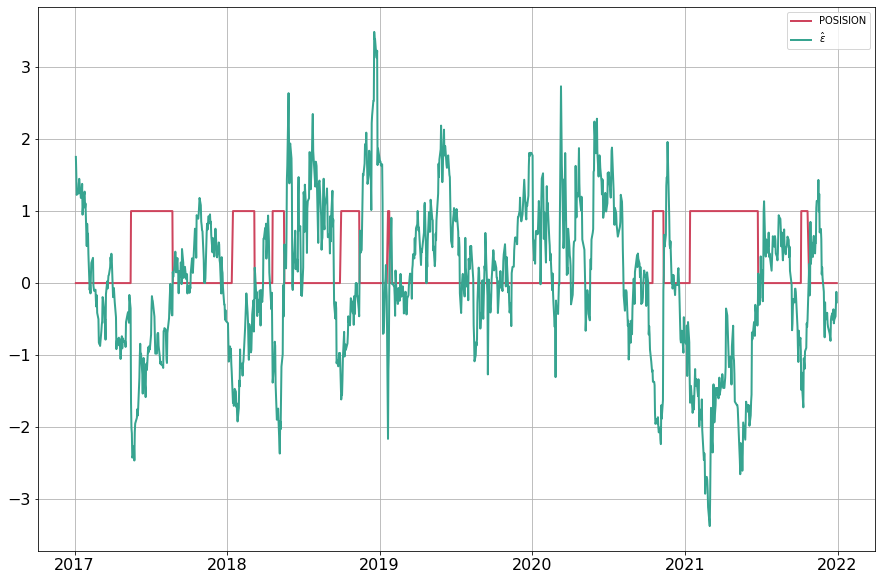

In [ ]:
# Other codes
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)

ax1.tick_params(axis='both',which='major',labelsize=16)
ax1.plot(signal_L,label='POSISION',color='#CE445D',linewidth=2)
ax1.plot(error,label= r"$\hat{\varepsilon}$",color='#37A490',linewidth=2)
ax1.legend()
ax1.grid(True)
plt.show()

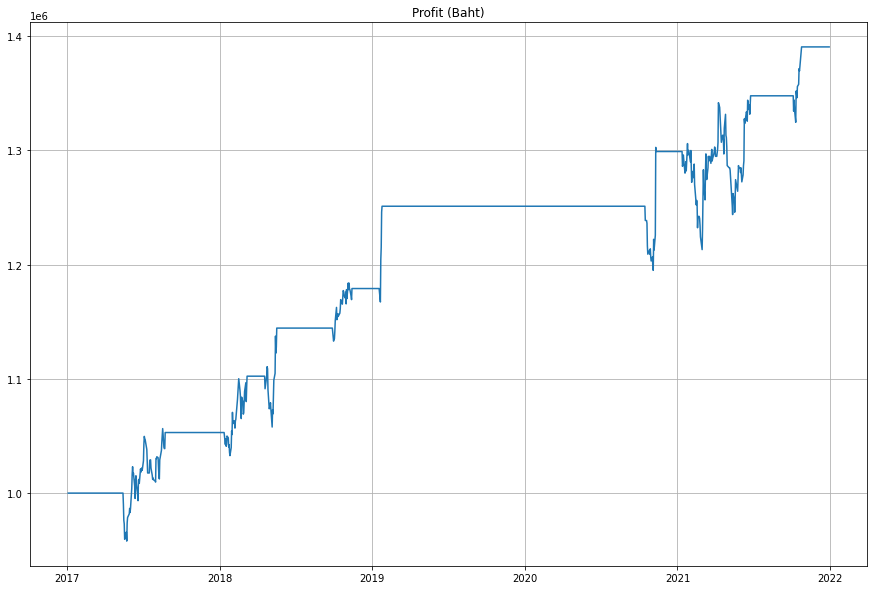

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(wealth_L)
plt.title('Profit (Baht)')
plt.grid()

In [ ]:
print(f"Gain(or Loss) at the end of 2021: {(wealth_L[-1]*(1/10000))}")

Gain(or Loss) at the end of 2021: [139.04155083]


## Solution:
* Gain(or Loss) at the end of 2021:Gain.
* Number of Long: 8 during 5 years.

# 11. Use the same spread function to trade on 2022 stocks, and repeat 9 and 10 

In [ ]:
# code here
close_prices2022 = dict()
for sym in set50:
  ticker = yf.Ticker(sym + ".BK")
  prices = ticker.history(start="2022-01-01", end="2022-12-31")
  close_prices2022[sym] =prices['Close']

[0.10555953] 11.122236365930725


Text(0.5, 1.0, '$\\hat{\\varepsilon} = y_{BDMS} - 0.1 * y_{PTTEP} - 11.12$')

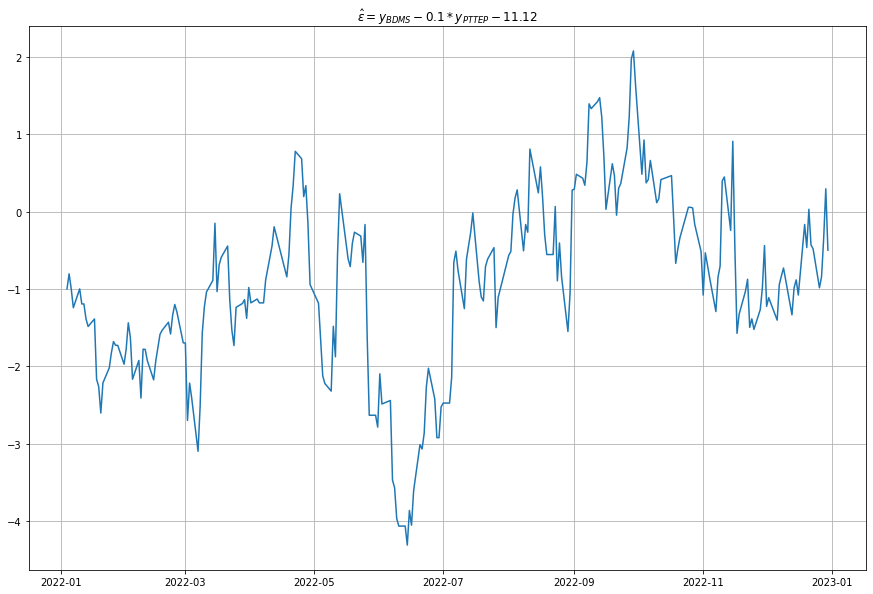

In [ ]:
Best_model, stat, p_value = sorted_models['BDMS', 'PTTEP']
print(Best_model.coef_, Best_model.intercept_)
error2022 = close_prices2022['BDMS'] - Best_model.coef_* close_prices2022['PTTEP']
error2022 -= Best_model.intercept_
plt.figure(figsize=(15,10))
plt.plot(error2022)
plt.grid()
plt.title(r"$\hat{\varepsilon} = y_{BDMS} - 0.1 * y_{PTTEP} - 11.12$")

In [ ]:
# build your own long only spread trading
a,b = Best_model.coef_, Best_model.intercept_
wealth_2022, signal_2022 = pairTrade(close_prices2022['BDMS'], close_prices2022['PTTEP'], z_th = s0, a = a , b = b, init_wealth=1_000_000, trans_cost=0.01)

<ipython-input-84-9ffb9b667ce4>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wealth = pd.Series()
<ipython-input-84-9ffb9b667ce4>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series()


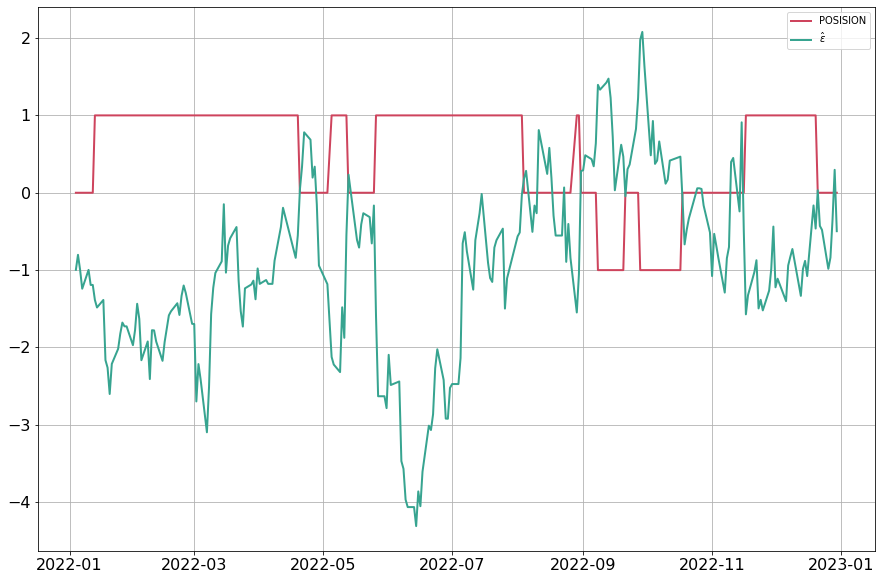

In [ ]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)

ax1.tick_params(axis='both',which='major',labelsize=16)
ax1.plot(signal_2022,label='POSISION',color='#CE445D',linewidth=2)
ax1.plot(error2022,label= r"$\hat{\varepsilon}$",color='#37A490',linewidth=2)
ax1.legend()
ax1.grid(True)
plt.show()

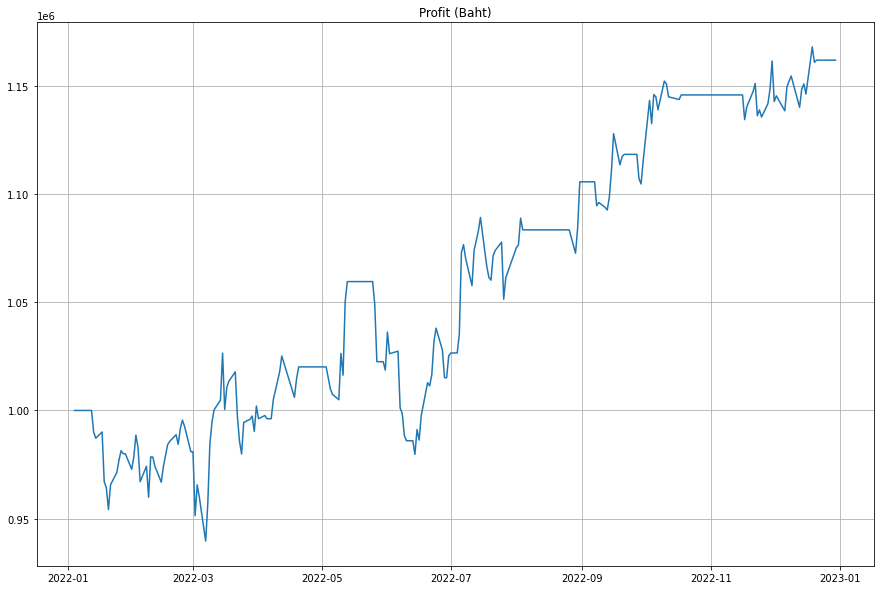

In [ ]:

plt.figure(figsize=(15,10))
plt.plot(wealth_2022)
plt.title('Profit (Baht)')
plt.grid()

In [ ]:
# build your own long only spread trading
a,b = Best_model.coef_, Best_model.intercept_
wealth_L2022, signal_L2022 = pairTradeLongOnly(close_prices2022['BDMS'], close_prices2022['PTTEP'], z_th = s0, a = a , b = b, init_wealth=1_000_000, trans_cost=0.01)

<ipython-input-243-26cbb16a10a5>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wealth = pd.Series()
<ipython-input-243-26cbb16a10a5>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series()


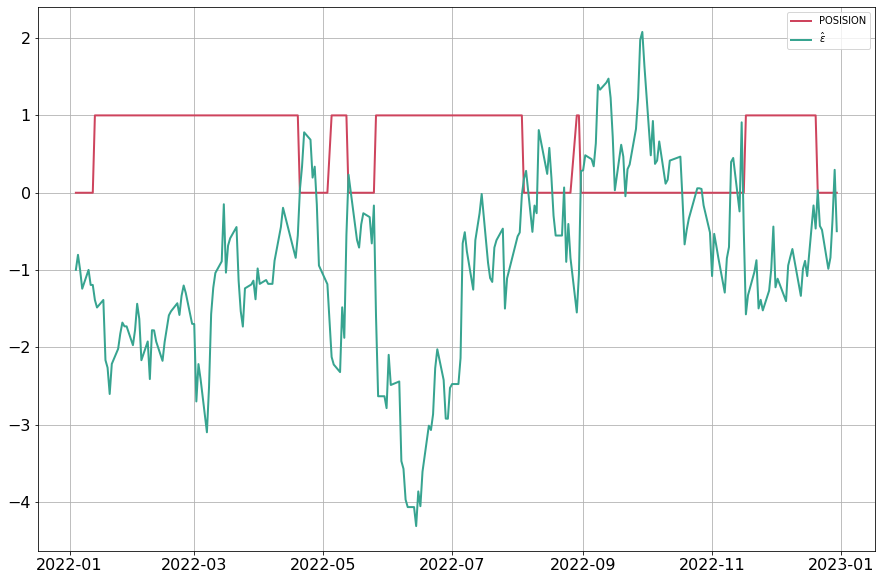

In [ ]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)

ax1.tick_params(axis='both',which='major',labelsize=16)
ax1.plot(signal_L2022,label='POSISION',color='#CE445D',linewidth=2)
ax1.plot(error2022,label= r"$\hat{\varepsilon}$",color='#37A490',linewidth=2)
ax1.legend()
ax1.grid(True)
plt.show()

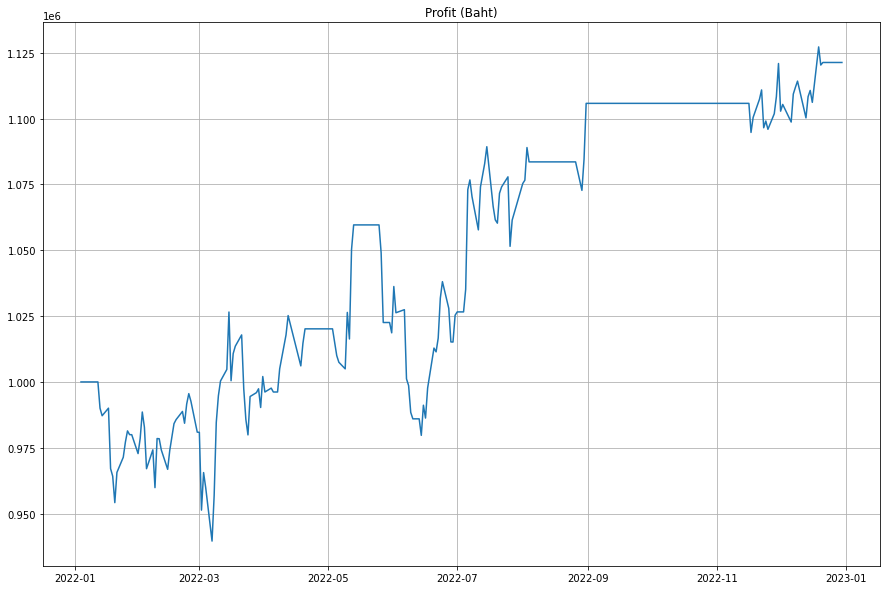

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(wealth_L2022)
plt.title('Profit (Baht)')
plt.grid()

## Solution:
* Gain (Loss) in 2022 with Long and short: Gain
* Gain (Loss) in 2022 with Long Only: Gain

# 12. In your opinion, do you think whether we should trade on the stock pair with negativen $\gamma$ or not? Provide the reason

## Solution: We should trade on the stock pair with negativen because when negativen $\gamma$ P-values is smallest